In [295]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
#from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score

import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/application_train.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/bureau.csv


In [296]:
train = pd.read_csv("/kaggle/input/home-credit-default-risk/application_train.csv")
test = pd.read_csv("/kaggle/input/home-credit-default-risk/application_test.csv")
sample_submission = pd.read_csv("/kaggle/input/home-credit-default-risk/sample_submission.csv")

In [297]:
pd.options.display.max_columns = 200

In [298]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


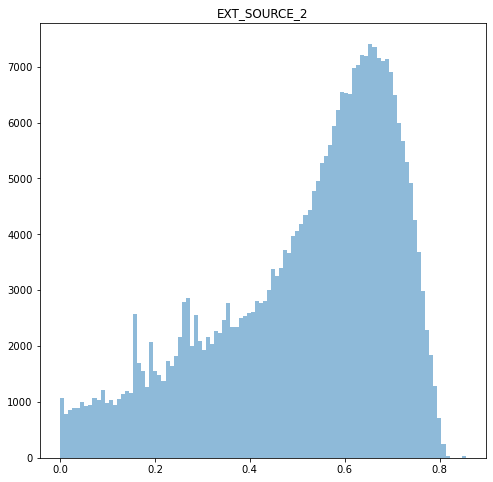

In [299]:
#
plt.figure(figsize= (8,8))
plt.hist(train['EXT_SOURCE_2'], bins = 100, label = 'test', alpha = 0.5)
#plt.hist(np.log1p(train['EXT_SOURCE_2'].fillna(0)), bins = 100, label = 'train', alpha = 0.5)
plt.title('EXT_SOURCE_2')
plt.show()

In [300]:
s_f = ['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_INCOME_TOTAL', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_2', 'FLAG_DOCUMENT_3', 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [301]:
heads = list(train.keys())
symbol_heads = []
digit_heads = []

for i, head in enumerate(heads):
    if isinstance(train[head][0], (float)) or str(train[head][0]).isdigit():
        if head != "Id": # не берем id как признак
            digit_heads.append(head)
    else:
        symbol_heads.append(head)

        
print("Число символьных признаков {}".format(str(len(symbol_heads))))
print("Число цифровых признаков {}".format(str(len(digit_heads))))

Число символьных признаков 19
Число цифровых признаков 103


In [302]:
digit_heads_log = []
digit_heads_not_log = []

for i, digit_head in enumerate(digit_heads): # итерируем цифровые признаки
    # убираем NaN и логариифмируем
    if digit_head != 'TARGET':
        train[digit_head] = train[digit_head].fillna(0)
        test[digit_head] = test[digit_head].fillna(0)
        try:
            train['LOG_'+digit_head] = np.log1p(train[digit_head])
            test['LOG_'+digit_head] = np.log1p(test[digit_head])
            digit_heads_log.append('LOG_'+digit_head)
        except:
            digit_heads_not_log.append(digit_head)            
            continue


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [303]:
categorical_features = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_CONTRACT_TYPE', 'ORGANIZATION_TYPE']
cf_enc = []

for i, cf in enumerate(categorical_features):
    le = LabelEncoder()
    le.fit(train[cf].fillna(0))
    train['ENC_'+cf] = le.transform(train[cf])
    test['ENC_'+cf] = le.transform(test[cf])
    cf_enc.append('ENC_'+cf)

0 CODE_GENDER
0 CODE_GENDER
0 CODE_GENDER
1 FLAG_OWN_CAR
1 FLAG_OWN_CAR
1 FLAG_OWN_CAR
2 FLAG_OWN_REALTY
2 FLAG_OWN_REALTY
2 FLAG_OWN_REALTY
3 NAME_CONTRACT_TYPE
3 NAME_CONTRACT_TYPE
3 NAME_CONTRACT_TYPE
4 ORGANIZATION_TYPE
4 ORGANIZATION_TYPE
4 ORGANIZATION_TYPE


In [304]:
# создаем оъединенный список признаков
all_features = [*cf_enc, *digit_heads_log]

Нормализация

In [305]:
scaler = preprocessing.StandardScaler()

for i, fc in enumerate(all_features):
    try:
        scaler.fit(train[[fc]])
        train[fc + '_NORM'] = scaler.transform( train[[fc]])
        test[fc + '_NORM'] = scaler.transform( test[[fc]])
    except:
        all_features.remove(fc)
        digit_heads_log.remove(fc)
        continue

In [306]:
s_f = all_features
roc_auc_list = []

kf = KFold(n_splits=5)
kf.get_n_splits(train)

model = SGDClassifier(loss = 'log', penalty = 'elasticnet')
for i, (train_index, test_index) in enumerate(kf.split(train)):
    
    X_train, X_test = train.loc[train_index, s_f], train.loc[test_index, s_f ]
    y_train, y_test = train.loc[train_index, 'TARGET'], train.loc[test_index, 'TARGET']

    model.fit(X_train, y_train)
    predict = model.predict_proba(X_test)[:,1]
    roc_auc = roc_auc_score(y_test, predict)
    roc_auc_list.append(roc_auc)
    print(i, roc_auc)
    
print("mean rmse for 5-fold: {}".format(str(np.mean(roc_auc_list))))
print("std roc_auc for 5-fold: {}".format(str(np.std(roc_auc_list))))

0 0.7152300704156648
1 0.7167552671868997
2 0.7085565324219824
3 0.7156618222987169
4 0.7163372118774995
mean rmse for 5-fold: 0.7145081808401527
std roc_auc for 5-fold: 0.0030222138790289396


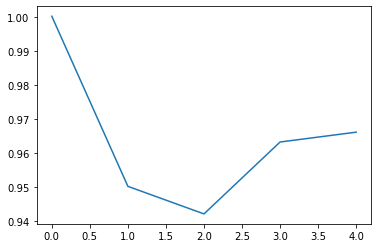

In [310]:
d = {'scores': [0.5, 0.63210 ,0.63188, 0.68814, 0.69030], 'roc_auc' :[0.49993, 0.66520, 0.67068, 0.71440, 0.71450]}
df = pd.DataFrame(data=d)
plt.plot( df['scores']/df['roc_auc'])
plt.show()

In [308]:
model = SGDClassifier(loss = 'log', penalty = 'elasticnet')
model.fit(train[s_f], train['TARGET'])
model.predict_proba(test[s_f]) [:,1]
sample_submission["TARGET"] = model.predict_proba(test[s_f]) [:,1]
sample_submission.to_csv("submission2.csv", index = None)